In [1]:
import pandas as pd
import numpy as np
import copy

from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os, sys, shutil, copy, time, random
from functools import partial

from sustain_dataset import *
from models import *
from utils import *

In [28]:
class Args:
    def __init__(self):
        self.log_root = './runs/unbiased'
        self.dataset = "gdp"

        self.train_bias_y = False
        self.train_bias_f = False
        self.train_cons = False
        self.train_calib = False
        self.re_calib = True
        self.re_bias_f = True
        self.re_bias_y = True

        # Modeling parameters
        self.model = 'small' #'linear' #'big'
        self.learning_rate = 1e-3
        self.batch_size = 1024
        self.num_bins = 0
        self.knn = 100

        # Run related parameters
        self.gpu = 0
        self.num_epoch = 500
        self.run_label = 0
        self.num_run = 10

args = Args()

device = torch.device('cuda:%d' % args.gpu)
args.device = device

In [18]:
args.knn = 200

class RecalibratorBias:
    def __init__(self, model, data, args, train=True, axis='label', verbose=False):
        self.axis = axis
#         self.flow = deeper_flow(layer_num=5, feature_size=20).to(args.device) 
        self.flow = NafFlow().to(args.device) # This flow model is too simple, might need more layers and latents?
        flow_optim = optim.Adam(self.flow.parameters(), lr=1e-3)
        
        k = args.knn
        assert k % 2 == 0
        
        inputs, labels = data
        inputs = inputs.to(args.device)
        labels = labels.to(args.device).flatten()
        
        if train:
            for iteration in range(5000):
                flow_optim.zero_grad()
                outputs = model(inputs).flatten()

                if axis == 'label':
                    ranking = torch.argsort(labels)
                else:
                    assert axis == 'prediction'
                    ranking = torch.argsort(outputs)

                sorted_labels = labels[ranking]
                sorted_outputs = outputs[ranking]

                smoothed_outputs = F.conv1d(sorted_outputs.view(1, 1, -1), 
                                            weight=(1./ (k+1) * torch.ones(1, 1, k+1, device=args.device, requires_grad=False)),
                                            padding=0).flatten()
                smoothed_labels = F.conv1d(sorted_labels.view(1, 1, -1), 
                                           weight=(1./ (k+1) * torch.ones(1, 1, k+1, device=args.device, requires_grad=False)),
                                           padding=0).flatten()
                
                adjusted_outputs, _ = self.flow(smoothed_outputs.view(-1, 1))
                loss_bias = (smoothed_labels - adjusted_outputs.view(-1)).pow(2).mean()
                loss_bias.backward()
                flow_optim.step()

                if verbose and iteration % 100 == 0:
                    print("Iteration %d, loss_bias=%.5f" % (iteration, loss_bias))
    
    def adjust(self, original_y):
        original_shape = original_y.shape
#        if self.axis == 'label':
#             adjusted_output = self.flow.invert(original_y.view(-1, 1))
#         else:
        adjusted_output, _ = self.flow(original_y.view(-1, 1))
        return adjusted_output.view(original_shape)
    

In [19]:
class Recalibrator:
    # This class is untested 
    def __init__(self, model, data, args, train=True, re_calib=False, re_bias_f=False, re_bias_y=False, verbose=False):
        self.args = args
        self.re_calib = re_calib
        self.re_bias_f = re_bias_f 
        self.re_bias_y = re_bias_y
        self.model = model  # regression model        
        self.flow = NafFlow(feature_size=40).to(args.device) # This flow model is too simple, might need more layers and latents?
        flow_optim = optim.Adam(self.flow.parameters(), lr=1e-3)
        # flow_scheduler = torch.optim.lr_scheduler.StepLR(flow_optim, step_size=100, gamma=0.9)

        k = args.knn
        assert k % 2 == 0
        assert re_calib or re_bias_f or re_bias_y 
        
        inputs, labels = data
        inputs = inputs.to(self.args.device)
        labels = labels.to(self.args.device).flatten()
        
        if train:
            for iteration in range(5000):
                flow_optim.zero_grad()
                loss_all = 0.0
                outputs = model(inputs).flatten()

                for objective in range(2):
                    if objective == 0 and self.re_bias_f:
                        ranking = torch.argsort(outputs)
                    elif objective == 1 and self.re_bias_y:
                        ranking = torch.argsort(labels)
                    else:
                        continue
                    sorted_labels = labels[ranking]
                    sorted_outputs = outputs[ranking]

                    smoothed_outputs = F.conv1d(sorted_outputs.view(1, 1, -1), 
                                                weight=(1./ (k+1) * torch.ones(1, 1, k+1, device=args.device, requires_grad=False)),
                                                padding=k // 2).flatten()
                    smoothed_labels = F.conv1d(sorted_labels.view(1, 1, -1), 
                                               weight=(1./ (k+1) * torch.ones(1, 1, k+1, device=args.device, requires_grad=False)),
                                               padding=k // 2).flatten()
                    adjusted_outputs, _ = self.flow(smoothed_outputs.view(-1, 1))
                    loss_bias = (smoothed_labels - adjusted_outputs.view(-1)).pow(2).mean()
                    loss_all += loss_bias 

                if re_calib:
                    labels = torch.sort(labels.flatten())[0]
                    outputs = torch.sort(outputs.flatten())[0]
                    adjusted_outputs, _ = self.flow(outputs.view(-1, 1))
                    loss_bias = (labels - adjusted_outputs.view(-1)).pow(2).mean()
                    loss_all += loss_bias

                loss_all.backward()
                flow_optim.step()
                # flow_scheduler.step()
                if verbose and iteration % 100 == 0:
                    print("Iteration %d, loss_bias=%.5f" % (iteration, loss_bias))
    
    def adjust(self, original_y):
        original_shape = original_y.shape
        adjusted_output, _ = self.flow(original_y.view(-1, 1))
        return adjusted_output.view(original_shape)


In [20]:
def plot_knn(model, data, args, axis='label'):
    k = args.knn
    assert k % 2 == 0

    inputs, labels = data
    inputs = inputs.to(args.device)
    labels = labels.to(args.device).flatten()
    outputs = model(inputs).flatten()

    if axis == 'label':
        ranking = torch.argsort(labels)
    else:
        assert axis == 'prediction'
        ranking = torch.argsort(outputs)

    sorted_labels = labels[ranking]
    sorted_outputs = outputs[ranking]

    smoothed_outputs = F.conv1d(sorted_outputs.view(1, 1, -1), 
                                weight=(1./ (k+1) * torch.ones(1, 1, k+1, device=args.device, requires_grad=False)),
                                padding=k // 2).flatten()
    smoothed_labels = F.conv1d(sorted_labels.view(1, 1, -1), 
                               weight=(1./ (k+1) * torch.ones(1, 1, k+1, device=args.device, requires_grad=False)),
                               padding=k // 2).flatten()
    return smoothed_labels[k//2+1:-k//2-1], smoothed_outputs[k//2+1:-k//2-1]

def plot_calibration(model, data, args):
    inputs, labels = data
    inputs = inputs.to(args.device)
    labels = labels.to(args.device)
    
    outputs = model(inputs)
    
    labels, _ = torch.sort(labels.flatten())
    outputs, _ = torch.sort(outputs.flatten())
    return labels, outputs

def smooth(y, box_pts=100):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='valid')
    return y_smooth

/atlas/u/chenlin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:85: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/atlas/u/chenlin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:93: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/atlas/u/chenlin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currentl

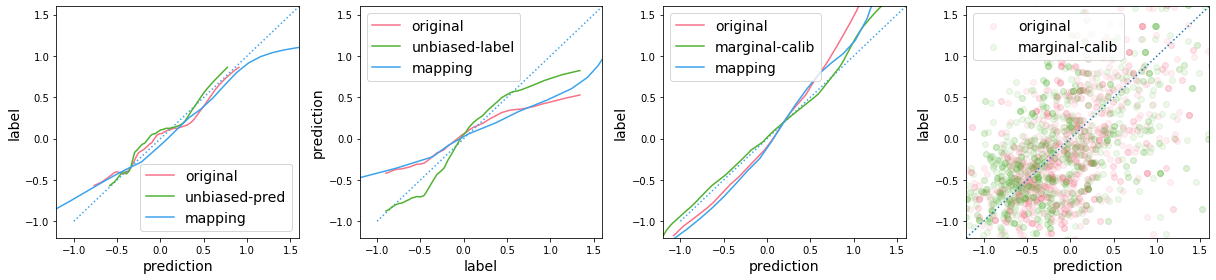

dir not exist gdp_knn/recalibration_model=small-False-False-False-False-True-True-True-bs=1024-bin=0-200-run=0
dir not exist gdp_knn/recalibration_model=small-False-False-False-False-True-True-True-bs=1024-bin=0-200-run=0
dir not exist gdp_knn/recalibration_model=small-False-False-False-False-True-True-True-bs=1024-bin=0-200-run=0
dir not exist gdp_knn/recalibration_model=small-False-False-False-False-True-True-True-bs=1024-bin=0-200-run=0
dir not exist gdp_knn/recalibration_model=small-False-False-False-False-True-True-True-bs=1024-bin=0-200-run=0
dir not exist gdp_knn/recalibration_model=small-False-False-False-False-True-True-True-bs=1024-bin=0-200-run=0
dir not exist gdp_knn/recalibration_model=small-False-False-False-False-True-True-True-bs=1024-bin=0-200-run=0
dir not exist gdp_knn/recalibration_model=small-False-False-False-False-True-True-True-bs=1024-bin=0-200-run=0
dir not exist gdp_knn/recalibration_model=small-False-False-False-False-True-True-True-bs=1024-bin=0-200-run=0
d

In [25]:
args.knn = 100
utility_points = 100
run_labels = np.arange(0, 1, 1)
for i, train_bias_y in enumerate([True, False]):
    for j, train_bias_f in enumerate([True, False]):
        for k, train_cons in enumerate([True, False]):
            for t, train_calib in enumerate([True, False]):

                # test_utility = np.zeros((utility_points + 18, len(run_labels)))
                test_utility = np.zeros((utility_points, len(run_labels)))
                test_labels = np.zeros((utility_points, len(run_labels)))

                labels_bias = None
                for run_label in run_labels:
                    args.name = '%s_knn/recalibration_model=%s-%r-%r-%r-%r-%r-%r-%r-bs=%d-bin=%d-%d-run=%d' % \
                            (args.dataset, args.model,
                             args.train_bias_y, args.train_bias_f, args.train_cons, args.train_calib, args.re_calib,
                             args.re_bias_f, args.re_bias_y,
                             args.batch_size, args.num_bins, args.knn, args.run_label)

                    args.log_dir = os.path.join(args.log_root, args.name)
                    if not os.path.isdir(args.log_dir):
                        print("dir not exist {}".format(args.name))
                        continue

                    ckpt = torch.load(os.path.join(args.log_dir, "ckpt.pth"))
                    train_dataset = ckpt[1]
                    test_dataset = ckpt[2]
                    val_dataset = ckpt[3]

                    # Define model and optimizer
                    model = model_list[args.model](train_dataset.x_dim).to(device)
                    # model = model_list[args.model](train_dataset.x_dim, act=F.tanh).to(device)
                    model.load_state_dict(ckpt[0])
                    
                    args.knn = 200
                    recalibrator_bias_f = RecalibratorBias(model, val_dataset[:], args, train=False, axis='prediction', verbose=True)
                    recalibrator_bias_y = RecalibratorBias(model, val_dataset[:], args, train=False, axis='label', verbose=True)
                    recalibrator_calib = Recalibrator(model, val_dataset[:], args, train=False, re_calib=True, verbose=True)
                    
                    recalibrator_bias_f.flow.load_state_dict(ckpt[5])
                    recalibrator_bias_y.flow.load_state_dict(ckpt[6])
                    recalibrator_calib.flow.load_state_dict(ckpt[7])
                    

                    model.eval()
                    import seaborn as sns
                    palette = sns.color_palette('husl', 3)

                    plot_lim = [-1.2, 1.6]
                    fontsize = 14
                    x = torch.linspace(val_dataset[:][1].min(), val_dataset[:][1].max(), 200).to(device)
                    with torch.no_grad():
                        plt.figure(figsize=(17, 4))
                        model.recalibrator = None

                        plt.subplot(1, 4, 1)
                        labels, outputs = plot_knn(model, test_dataset[:], args, axis='prediction')
                        plt.plot(smooth(outputs.cpu()), smooth(labels.cpu()), c=palette[0], label='original') 
                        plt.plot([-1.0, 2.0], [-1.0, 2.0], linestyle=':', c=palette[2])
                        plt.xlabel('prediction', fontsize=fontsize)
                        plt.ylabel('label', fontsize=fontsize)
                        plt.xlim(plot_lim)
                        plt.ylim(plot_lim)

                        plt.subplot(1, 4, 2)
                        labels, outputs = plot_knn(model, test_dataset[:], args, axis='label')
                        plt.plot(smooth(labels.cpu()), smooth(outputs.cpu()), c=palette[0], label='original') 
                        plt.plot([-1.0, 2.0], [-1.0, 2.0], linestyle=':', c=palette[2])
                        plt.xlabel('label', fontsize=fontsize)
                        plt.ylabel('prediction', fontsize=fontsize) 
                        plt.xlim(plot_lim)
                        plt.ylim(plot_lim)

                        plt.subplot(1, 4, 3)
                        labels, outputs = plot_calibration(model, test_dataset[:], args)
                        plt.plot(smooth(outputs.cpu()), smooth(labels.cpu()), c=palette[0], label='original')
                        plt.plot([-1.0, 2.0], [-1.0, 2.0], linestyle=':', c=palette[2])
                        plt.xlabel('prediction', fontsize=fontsize) 
                        plt.ylabel('label', fontsize=fontsize)
                        plt.xlim(plot_lim)
                        plt.ylim(plot_lim)


                        plt.subplot(1, 4, 1)
                        model.recalibrator = recalibrator_bias_f
                        labels, outputs = plot_knn(model, test_dataset[:], args, axis='prediction')
                        plt.plot(smooth(outputs.cpu()), smooth(labels.cpu()), c=palette[1], label='unbiased-pred') 
                        y = recalibrator_bias_f.adjust(x.view(-1, 1))
                        plt.plot(x.cpu(), y.detach().cpu(), c=palette[2], label='mapping')
                        plt.legend(fontsize=fontsize)

                        plt.subplot(1, 4, 2)
                        model.recalibrator = recalibrator_bias_y
                        labels, outputs = plot_knn(model, test_dataset[:], args, axis='label')
                        plt.plot(smooth(labels.cpu()), smooth(outputs.cpu()), c=palette[1], label='unbiased-label') 
                        y = recalibrator_bias_y.adjust(x.view(-1, 1))
                        plt.plot(y.detach().cpu(), x.cpu(), c=palette[2], label='mapping')
                        plt.legend(fontsize=fontsize)

                        plt.subplot(1, 4, 3)
                        model.recalibrator = recalibrator_calib
                        labels, outputs = plot_calibration(model, test_dataset[:], args)
                        plt.plot(smooth(outputs.cpu()), smooth(labels.cpu()), c=palette[1], label='marginal-calib')
                        y = recalibrator_calib.adjust(x.view(-1, 1))
                        plt.plot(x.cpu(), y.detach().cpu(), c=palette[2], label='mapping')
                        plt.legend(fontsize=fontsize)

                        plt.subplot(1, 4, 4)
                        model.recalibrator = None
                        inputs, labels = val_dataset[:]
                        inputs = inputs.to(args.device)
                        labels = labels.to(args.device).flatten()
                        outputs = model(inputs)
                        adjusted_outputs = recalibrator_calib.adjust(outputs)
                        idx = np.random.choice(np.arange(len(labels)), 1000)
                        plt.scatter(outputs.cpu()[idx], labels.cpu()[idx], alpha=0.1, c=palette[0], label='original')
                        plt.scatter(adjusted_outputs.cpu()[idx], labels.cpu()[idx], alpha=0.1, c=palette[1], label='marginal-calib')
                        plt.plot([-1.5, 2.0], [-1.5, 2.0], linestyle=':')
                        plt.xlim(plot_lim)
                        plt.ylim(plot_lim)
                        plt.xlabel('prediction', fontsize=fontsize) 
                        plt.ylabel('label', fontsize=fontsize)
                        plt.legend(fontsize=fontsize)
                        plt.tight_layout()
#                         plt.savefig('plots/recalib_curve.png')

                        plt.show()

    

In [48]:
def tax_utility(difference, beta=1.):
    # difference: y_0 - pred
    return beta * difference


def compute_utility(model, test_dataset, a=torch.relu, r=torch.log, y_0=0.3):
    inputs, labels = test_dataset[:]
    inputs, labels = inputs.to(device), labels.to(device)
    pred = model(inputs).reshape(-1)
    labels = labels.reshape(-1)
    finacial_aid = a(y_0 - pred)
    after_finacial_aid = labels + finacial_aid
    # utility = r(2.+after_finacial_aid) # worked well
    utility = r(3.+after_finacial_aid)
    utility = utility.mean(dim=0)
    return utility.data.item(), finacial_aid.sum().data.item()

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='valid')
    return y_smooth

# original
def plot_errbar_original(ax, x, y, c=None, label=None):
    mean = np.mean(y, axis=1)
    std = np.std(y, axis=1) / np.sqrt(y.shape[1])
    ax.plot(x, mean, label=label, c=c, linewidth=2.)
    ax.fill_between(x, mean-std, mean+std, color=c, alpha=0.01)

from scipy.interpolate import interp1d
def plot_errbar(ax, x, y, x1=600, x2=2000, c=None, label=None):
    # import pdb
    # pdb.set_trace()
#     x1 = x.min()
#     x2 = x.max()
    
    for i in range(y.shape[1]):
        f2 = interp1d(x[:, i], y[:, i], kind='linear')
#         x1 = x[:, i].min()
#         x2 = x[:, i].max()
        y[:, i] = f2(np.linspace(x1, x2, len(x)))

    mean = np.mean(y, axis=1)
    std = np.std(y, axis=1) / np.sqrt(y.shape[1])
    x = np.linspace(x1, x2, len(mean))
    ax.plot(x, mean, label=label, c=c, linewidth=3.)
    # ax.fill_between(x, mean-std, mean+std, color=c, alpha=0.01)

/atlas/u/chenlin/miniconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/atlas/u/chenlin/miniconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


(array([1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45]),
 <a list of 7 Text yticklabel objects>)

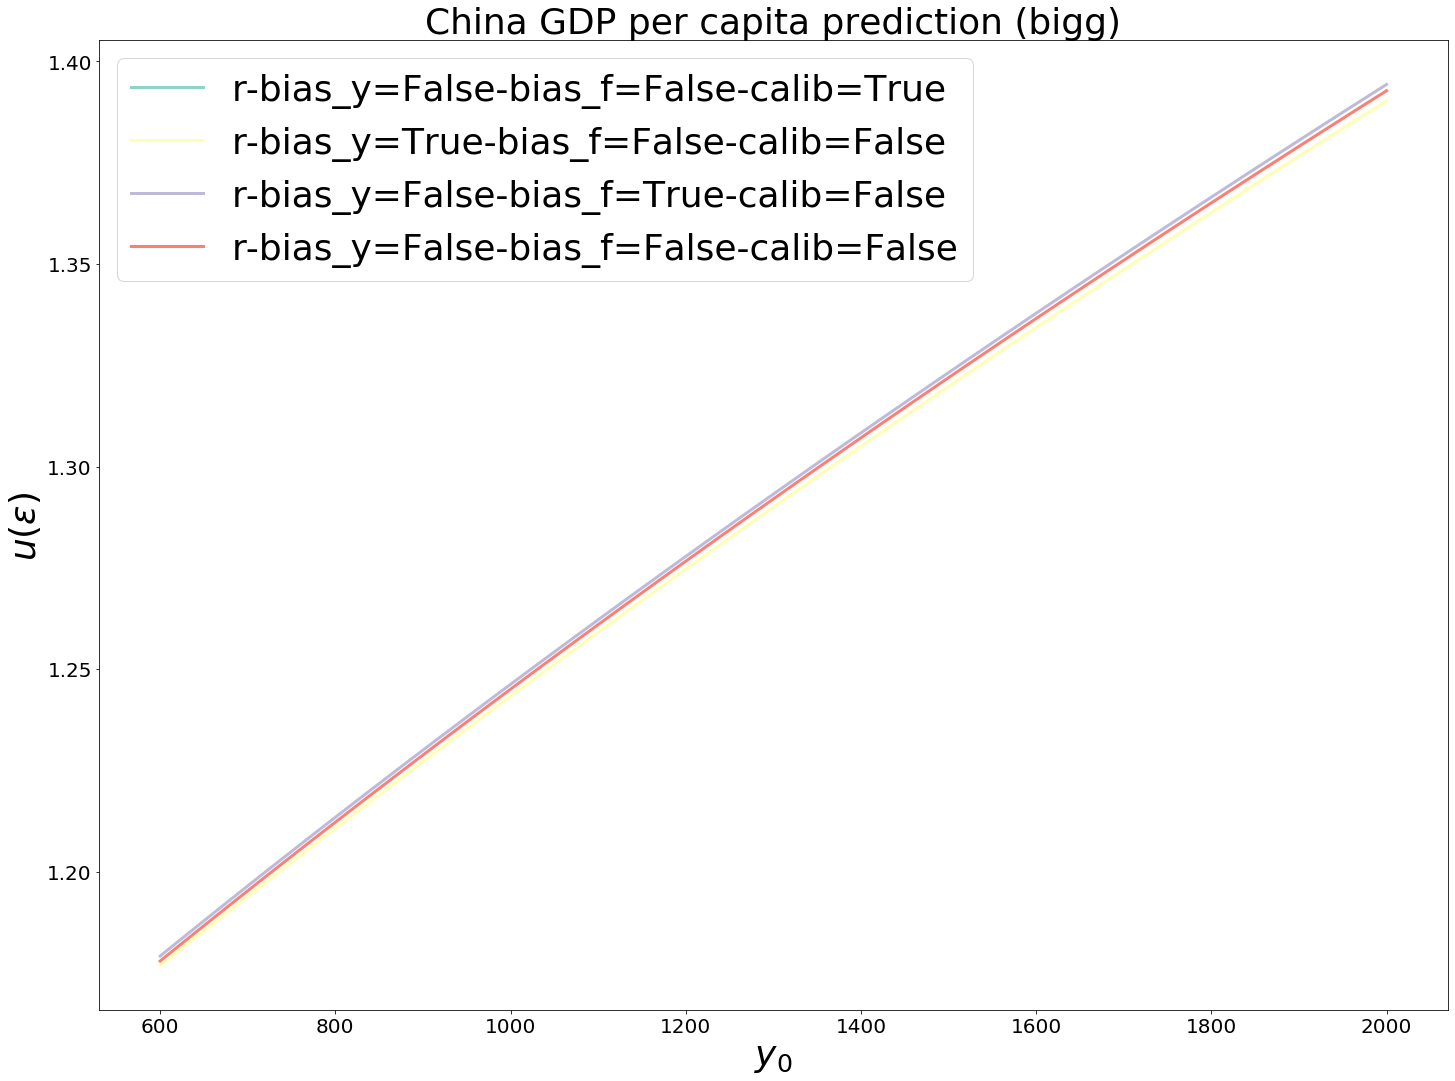

In [56]:
args = Args()
args.knn = 100
args.model = "bigg"

device = torch.device('cuda:%d' % args.gpu)
args.device = device
start_time = time.time()
run_labels = range(0, 10, 1)
utility_points = 100
fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(20, 15))
colors = plt.cm.get_cmap('Set3').colors
# colors = ['r', 'g', 'c', 'm', 'k', 'orange', 'r', 'black']

for i in range(4):
    if i == 3:
        re_bias_y = re_bias_f = re_calib = False
    elif i == 1:
        re_bias_y = True
        re_bias_f = re_calib = False
    elif i == 2:
        re_bias_f = True
        re_bias_y = re_calib = False
    elif i == 0:
        re_calib = True
        re_bias_y = re_bias_f = False
        
    # test_utility = np.zeros((utility_points + 18, len(run_labels)))
    test_utility = np.zeros((utility_points, len(run_labels)))
    test_labels = np.zeros((utility_points, len(run_labels)))

    labels_bias = None
    for run_label in run_labels:
        args.knn = 100
        args.name = '%s_knn/recalibration_model=%s-%r-%r-%r-%r-%r-%r-%r-bs=%d-bin=%d-%d-run=%d' % \
                (args.dataset, args.model,
                 False, False, False, False, args.re_calib,
                 args.re_bias_f, args.re_bias_y,
                 args.batch_size, args.num_bins, args.knn, args.run_label)

        args.log_dir = os.path.join(args.log_root, args.name)
        if not os.path.isdir(args.log_dir):
            print("dir not exist {}".format(args.name))
            continue

        ckpt = torch.load(os.path.join(args.log_dir, "ckpt.pth"))
        train_dataset = ckpt[1]
        test_dataset = ckpt[2]
        val_dataset = ckpt[3]

        # Define model and optimizer
        model = model_list[args.model](train_dataset.x_dim).to(device)
        # model = model_list[args.model](train_dataset.x_dim, act=F.tanh).to(device)
        model.load_state_dict(ckpt[0])

        args.knn = 200
        recalibrator_bias_f = RecalibratorBias(model, val_dataset[:], args, train=False, axis='prediction', verbose=True)
        recalibrator_bias_y = RecalibratorBias(model, val_dataset[:], args, train=False, axis='label', verbose=True)
        recalibrator_calib = Recalibrator(model, val_dataset[:], args, train=False, re_calib=True, verbose=True)

        recalibrator_bias_f.flow.load_state_dict(ckpt[5])
        recalibrator_bias_y.flow.load_state_dict(ckpt[6])
        recalibrator_calib.flow.load_state_dict(ckpt[7])
        model.recalibrator = None
        
        model.eval()
        if re_bias_y:
            model.recalibrator = recalibrator_bias_y
        elif re_bias_f:
            model.recalibrator = recalibrator_bias_f
        elif re_calib:
            model.recalibrator = recalibrator_calib
            
        # Performance evaluation
        with torch.no_grad():
            u_array_bias = []
            labels_bias = []

            for y0 in np.linspace(-0.5, 2, utility_points):
                u, a = compute_utility(model, test_dataset, y_0=y0)
                # u, a = compute_utility(model, test_dataset, r=(lambda x: torch.pow(x, 1/2.)), y_0=y0)
                # u = compute_utility(model, test_dataset, a=tax_utility, y_0=y0)  # .data.item()
                #     print(u)
                u_array_bias.append(u)
                labels_bias.append(a)

        test_utility[:utility_points, run_label] = np.array(u_array_bias) #smooth(np.array(u_array_bias), 18)
        test_labels[:utility_points, run_label] = np.array(labels_bias)
      
    if isinstance(labels_bias, type(None)):
        continue
    import pdb
#     pdb.set_trace()
    plot_errbar(ax1, test_labels[:utility_points], test_utility[:utility_points],
                label='r-bias_y=%r-bias_f=%r-calib=%r' % (re_bias_y, re_bias_f, re_calib),
                c=colors[i])


# ax1.set_ylim([0.6, 1.5])
# ax1.set_ylim([1., 1.5])
fontsize = 36
if args.dataset == "gdp":
    ax1.set_title("China GDP per capita prediction ({})".format(args.model), fontsize=fontsize)
else:
    ax1.set_title("Uganda poverty prediction", fontsize=fontsize)

ax1.legend(fontsize=fontsize)
ax1.set_xlabel(r"$y_0$", fontsize=fontsize)
ax1.set_ylabel(r"$u(\epsilon)$", fontsize=fontsize)

plt.tight_layout()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.savefig('plots/result_{}_knn.png'.format(args.dataset))
# plt.close()

In [ ]:
# !ls ./runs/unbiased/gdp_knn/recalibration_model=small-False-False-False-False-True-True

In [ ]:
# recalibrator = RecalibratorBias_flow(model, )
model.eval()
import seaborn as sns
palette = sns.color_palette('husl', 3)

plot_lim = [-1.2, 1.6]
fontsize = 14
x = torch.linspace(val_dataset[:][1].min(), val_dataset[:][1].max(), 200).to(device)
with torch.no_grad():
    plt.figure(figsize=(17, 4))
    model.recalibrator = None
    
    plt.subplot(1, 4, 1)
    labels, outputs = plot_knn(model, test_dataset[:], args, axis='prediction')
    plt.plot(smooth(outputs.cpu()), smooth(labels.cpu()), c=palette[0], label='original') 
    plt.plot([-1.0, 2.0], [-1.0, 2.0], linestyle=':', c=palette[2])
    plt.xlabel('prediction', fontsize=fontsize)
    plt.ylabel('label', fontsize=fontsize)
    plt.xlim(plot_lim)
    plt.ylim(plot_lim)
    
    plt.subplot(1, 4, 2)
    labels, outputs = plot_knn(model, test_dataset[:], args, axis='label')
    plt.plot(smooth(labels.cpu()), smooth(outputs.cpu()), c=palette[0], label='original') 
    plt.plot([-1.0, 2.0], [-1.0, 2.0], linestyle=':', c=palette[2])
    plt.xlabel('label', fontsize=fontsize)
    plt.ylabel('prediction', fontsize=fontsize) 
    plt.xlim(plot_lim)
    plt.ylim(plot_lim)
    
    plt.subplot(1, 4, 3)
    labels, outputs = plot_calibration(model, test_dataset[:], args)
    plt.plot(smooth(outputs.cpu()), smooth(labels.cpu()), c=palette[0], label='original')
    plt.plot([-1.0, 2.0], [-1.0, 2.0], linestyle=':', c=palette[2])
    plt.xlabel('prediction', fontsize=fontsize) 
    plt.ylabel('label', fontsize=fontsize)
    plt.xlim(plot_lim)
    plt.ylim(plot_lim)
    

    plt.subplot(1, 4, 1)
    model.recalibrator = recalibrator_bias_f
    labels, outputs = plot_knn(model, test_dataset[:], args, axis='prediction')
    plt.plot(smooth(outputs.cpu()), smooth(labels.cpu()), c=palette[1], label='unbiased-pred') 
    y = recalibrator_bias_f.adjust(x.view(-1, 1))
    plt.plot(x.cpu(), y.detach().cpu(), c=palette[2], label='mapping')
    plt.legend(fontsize=fontsize)
    
    plt.subplot(1, 4, 2)
    model.recalibrator = recalibrator_bias_y
    labels, outputs = plot_knn(model, test_dataset[:], args, axis='label')
    plt.plot(smooth(labels.cpu()), smooth(outputs.cpu()), c=palette[1], label='unbiased-label') 
    y = recalibrator_bias_y.adjust(x.view(-1, 1))
    plt.plot(y.detach().cpu(), x.cpu(), c=palette[2], label='mapping')
    plt.legend(fontsize=fontsize)
    
    plt.subplot(1, 4, 3)
    model.recalibrator = recalibrator_calib
    labels, outputs = plot_calibration(model, test_dataset[:], args)
    plt.plot(smooth(outputs.cpu()), smooth(labels.cpu()), c=palette[1], label='marginal-calib')
    y = recalibrator_calib.adjust(x.view(-1, 1))
    plt.plot(x.cpu(), y.detach().cpu(), c=palette[2], label='mapping')
    plt.legend(fontsize=fontsize)
    
    plt.subplot(1, 4, 4)
    model.recalibrator = None
    inputs, labels = val_dataset[:]
    inputs = inputs.to(args.device)
    labels = labels.to(args.device).flatten()
    outputs = model(inputs)
    adjusted_outputs = recalibrator_calib.adjust(outputs)
    idx = np.random.choice(np.arange(len(labels)), 1000)
    plt.scatter(outputs.cpu()[idx], labels.cpu()[idx], alpha=0.1, c=palette[0], label='original')
    plt.scatter(adjusted_outputs.cpu()[idx], labels.cpu()[idx], alpha=0.1, c=palette[1], label='marginal-calib')
    plt.plot([-1.5, 2.0], [-1.5, 2.0], linestyle=':')
    plt.xlim(plot_lim)
    plt.ylim(plot_lim)
    plt.xlabel('prediction', fontsize=fontsize) 
    plt.ylabel('label', fontsize=fontsize)
    plt.legend(fontsize=fontsize)
    plt.tight_layout()
    plt.savefig('plots/recalib_curve.png')
    
    plt.show()

In [28]:


start_time = time.time()

if args.num_bins == 0:
    eval_bias = eval_bias_knn
    assert args.knn > 10 and args.knn % 2 == 0
    

while True:
    args.name = '%s/model=%s-%r-%r-%r-%r-%r-%r-%r-bs=%d-bin=%d-%d-run=%d' % \
        (args.dataset, args.model, 
         args.train_bias_y, args.train_bias_f, args.train_cons, args.train_calib, args.re_calib, args.re_bias_f, args.re_bias_y,
         args.batch_size, args.num_bins, args.knn, args.run_label)
    args.log_dir = os.path.join(args.log_root, args.name)
    if not os.path.isdir(args.log_dir):
        os.makedirs(args.log_dir)
        break
    args.run_label += 1
print("Run number = %d" % args.run_label)
writer = SummaryWriter(args.log_dir)
log_writer = open(os.path.join(args.log_dir, 'results.txt'), 'w')

global_iteration = 0
random.seed(args.run_label)  # Set a different random seed for different run labels
torch.manual_seed(args.run_label)

def log_scalar(name, value, epoch):
    writer.add_scalar(name, value, epoch)
    log_writer.write('%f ' % value)


Run number = 0


In [168]:
models = []

In [169]:
# Define dataset and dataset loader
Dataset = dataset_list[args.dataset]
total_data = Dataset().total_data
permutation = torch.randperm(total_data)

if args.re_calib or args.re_bias_y or args.re_bias_f:
    train_dataset = Dataset(train=True, val=False, random_permute=False, val_partition=0.2, partition=0.3, permutation=permutation)
    val_dataset = Dataset(train=False, val=True, random_permute=False, val_partition=0.2, partition=0.3, permutation=permutation)
    test_dataset = Dataset(train=False, val=False, random_permute=False, val_partition=0.2, partition=0.3, permutation=permutation)
else:
    train_dataset = Dataset(train=True, random_permute=False, permutation=permutation)
    test_dataset = Dataset(train=False, random_permute=False, permutation=permutation) # could have overlapping
    
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)
train_bb_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=4)


In [170]:
# # Define model and optimizer
# model = model_list[args.model](train_dataset.x_dim).to(device)
# optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args.num_epoch // 20, gamma=0.9) 
# # train_bb_iter = itertools.cycle(train_bb_loader)

# bb = iter(train_bb_loader).next()
# bb_counter = 0   # Only refresh bb every 100 steps to save computation


In [171]:
for i in range(3):
    # Define model and optimizer
    model = model_list[args.model](train_dataset.x_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args.num_epoch // 20, gamma=0.9) 
    # train_bb_iter = itertools.cycle(train_bb_loader)

    bb = iter(train_bb_loader).next()
    bb_counter = 0   # Only refresh bb every 100 steps to save computation

    for epoch in range(20):
        model.train()
        train_l2_all = []
        for i, data in enumerate(train_loader):
            # Minimize L2
            optimizer.zero_grad()
            loss_l2 = eval_l2(model, data, args)
            train_l2_all.append(loss_l2.detach())
            loss_l2.mean().backward()
            optimizer.step()

            # Minimize any of the special objectives
            optimizer.zero_grad()

            if args.train_bias_y:
                loss_bias, _ = eval_bias(model, bb, args, axis='label')
                writer.add_scalar('bias_loss_y', loss_bias, global_iteration)
                loss_bias.backward()

            if args.train_bias_f:
                loss_bias, _ = eval_bias(model, bb, args, axis='prediction')
                writer.add_scalar('bias_loss_f', loss_bias, global_iteration)
                loss_bias.backward()                

            if args.train_cons:
                loss_cons, _ = eval_cons(model, bb, args, alpha=alpha)
                writer.add_scalar('cons_loss', loss_cons, global_iteration)
                loss_cons.backward()

            if args.train_calib:
                loss_calib, _ = eval_calibration(model, bb, args)
                writer.add_scalar('calib_loss', loss_calib, global_iteration)
                loss_calib.backward()
            optimizer.step()

            global_iteration += 1

            bb_counter += 1
            if bb_counter > 100:
                bb = iter(train_bb_loader).next()
                bb_counter = 0

        # Performance evaluation
        model.eval()
        with torch.no_grad():
            # Log the train and test l2
            train_l2_all = torch.cat(train_l2_all).mean()
            log_scalar('train_l2', train_l2_all.item(), global_iteration)

            test_l2_all = eval_l2(model, test_dataset[:], args).mean()
            log_scalar('test_l2', test_l2_all.item(), global_iteration)

    #             train_bias_err, train_cons_err = make_plot(model, train_dataset[:], args, ('train-%d' % epoch) + '-%s.png', 
    #                                                        do_plot=(epoch % 100 == 0), alpha=alpha)
    #             test_bias_err, test_cons_err = make_plot(model, test_dataset[:], args, ('test-%d' % epoch) + '-%s.png',
    #                                                     do_plot=(epoch % 100 == 0), alpha=alpha)
            # train_calib_err, _ = eval_calibration(model, test_dataset[:], args)
            test_bias_y, _ = eval_bias(model, test_dataset[:], args, axis='label')
            test_bias_f, _ = eval_bias(model, test_dataset[:], args, axis='prediction')
            test_calib_err, _ = eval_calibration(model, test_dataset[:], args)

    #             log_scalar('train_bias_loss', train_bias_err, global_iteration)
    #             log_scalar('train_cons_loss', train_cons_err, global_iteration)
            log_scalar('test_bias_y', test_bias_y, global_iteration)
            log_scalar('test_bias_f', test_bias_f, global_iteration)
            log_scalar('test_calib_loss', test_calib_err, global_iteration)

            thresholds = torch.linspace(0.1, 0.9, 8).to(device)
            fn, fp = eval_decisions(model, test_dataset[:], args, thresholds)
            for ti in range(8):
                log_scalar('fn_%d' % ti, fn[ti], global_iteration)
                log_scalar('fp_%d' % ti, fp[ti], global_iteration)
            log_scalar('fp+fn_all', fn.mean() + fp.mean(), global_iteration)

        log_writer.write('\n')
        log_writer.flush()

        print('global_iteration %d, time %.2f, %s' % (global_iteration, time.time() - start_time, args.name))
        scheduler.step()
    models.append(model)

global_iteration 13728, time 7453.28, gdp/model=small-False-False-False-False-True-True-False-bs=1024-bin=0-100-run=0
global_iteration 13824, time 7454.10, gdp/model=small-False-False-False-False-True-True-False-bs=1024-bin=0-100-run=0
global_iteration 13920, time 7454.90, gdp/model=small-False-False-False-False-True-True-False-bs=1024-bin=0-100-run=0
global_iteration 14016, time 7455.71, gdp/model=small-False-False-False-False-True-True-False-bs=1024-bin=0-100-run=0
global_iteration 14112, time 7456.54, gdp/model=small-False-False-False-False-True-True-False-bs=1024-bin=0-100-run=0
global_iteration 14208, time 7457.37, gdp/model=small-False-False-False-False-True-True-False-bs=1024-bin=0-100-run=0
global_iteration 14304, time 7458.07, gdp/model=small-False-False-False-False-True-True-False-bs=1024-bin=0-100-run=0
global_iteration 14400, time 7458.87, gdp/model=small-False-False-False-False-True-True-False-bs=1024-bin=0-100-run=0
global_iteration 14496, time 7459.69, gdp/model=small-Fa

In [5]:
args.knn = 200

class RecalibratorBias:
    def __init__(self, model, data, args, train=True, axis='label', verbose=False):
        self.axis = axis
#         self.flow = deeper_flow(layer_num=5, feature_size=20).to(args.device) 
        self.flow = NafFlow().to(args.device) # This flow model is too simple, might need more layers and latents?
        flow_optim = optim.Adam(self.flow.parameters(), lr=1e-3)
        
        k = args.knn
        assert k % 2 == 0
        
        inputs, labels = data
        inputs = inputs.to(args.device)
        labels = labels.to(args.device).flatten()
        
        if train:
            for iteration in range(5000):
                flow_optim.zero_grad()
                outputs = model(inputs).flatten()

                if axis == 'label':
                    ranking = torch.argsort(labels)
                else:
                    assert axis == 'prediction'
                    ranking = torch.argsort(outputs)

                sorted_labels = labels[ranking]
                sorted_outputs = outputs[ranking]

                smoothed_outputs = F.conv1d(sorted_outputs.view(1, 1, -1), 
                                            weight=(1./ (k+1) * torch.ones(1, 1, k+1, device=args.device, requires_grad=False)),
                                            padding=0).flatten()
                smoothed_labels = F.conv1d(sorted_labels.view(1, 1, -1), 
                                           weight=(1./ (k+1) * torch.ones(1, 1, k+1, device=args.device, requires_grad=False)),
                                           padding=0).flatten()

                # Generate some pseudo datapoints 
    #             max_val = smoothed_outputs.max() 
    #             pseudo_outputs_max = max_val + torch.linspace(0, 1, len(inputs) // 10, device=args.device) 
    #             pseudo_labels_max = max_val + torch.linspace(0, 1, len(inputs) // 10, device=args.device)  * \
    #                 (smoothed_labels[-10:].mean() - smoothed_labels[-20:-10].mean()) / (smoothed_outputs[-10:].mean() - smoothed_outputs[-20:-10].mean())

    #             smoothed_outputs = torch.cat([smoothed_outputs, pseudo_outputs_max])
    #             smoothed_labels = torch.cat([])

    #             pseudo_outputs = torch.linspace(max_val, )
    #             print(smoothed_outputs.shape)
    #             print(smoothed_labels.shape)
    #             loss_bias = smoothed_labels - smoothed_outputs

    #             if axis == 'label':
    #                 adjusted_labels, _ = self.flow(smoothed_labels.view(-1, 1))
    # #                 adjusted_outputs = self.flow.invert(smoothed_outputs.view(-1, 1))
    #                 loss_bias = (adjusted_labels.view(-1) - smoothed_outputs).pow(2).mean()
    #             elif axis == 'prediction':
                adjusted_outputs, _ = self.flow(smoothed_outputs.view(-1, 1))
                loss_bias = (smoothed_labels - adjusted_outputs.view(-1)).pow(2).mean()
                loss_bias.backward()
                flow_optim.step()

                if verbose and iteration % 100 == 0:
                    print("Iteration %d, loss_bias=%.5f" % (iteration, loss_bias))
    
    def adjust(self, original_y):
        original_shape = original_y.shape
#        if self.axis == 'label':
#             adjusted_output = self.flow.invert(original_y.view(-1, 1))
#         else:
        adjusted_output, _ = self.flow(original_y.view(-1, 1))
        return adjusted_output.view(original_shape)
    
# recalibrator_bias_f_ = []
# recalibrator_bias_y_ = []
# for i in range(len(models)):
#     recalibrator_bias_f = RecalibratorBias(models[i], val_dataset[:], args, axis='prediction', verbose=True)
#     recalibrator_bias_y = RecalibratorBias(models[i], val_dataset[:], args, axis='label', verbose=True)
#     recalibrator_bias_f_.append(recalibrator_bias_f)
#     recalibrator_bias_y_.append(recalibrator_bias_y)    

In [6]:
class Recalibrator:
    # This class is untested 
    def __init__(self, model, data, args, train=True, re_calib=False, re_bias_f=False, re_bias_y=False, verbose=False):
        self.args = args
        self.re_calib = re_calib
        self.re_bias_f = re_bias_f 
        self.re_bias_y = re_bias_y
        self.model = model  # regression model        
        self.flow = NafFlow(feature_size=40).to(args.device) # This flow model is too simple, might need more layers and latents?
        flow_optim = optim.Adam(self.flow.parameters(), lr=1e-3)
        # flow_scheduler = torch.optim.lr_scheduler.StepLR(flow_optim, step_size=100, gamma=0.9)

        k = args.knn
        assert k % 2 == 0
        assert re_calib or re_bias_f or re_bias_y 
        
        inputs, labels = data
        inputs = inputs.to(self.args.device)
        labels = labels.to(self.args.device).flatten()
        
        if train:
            for iteration in range(5000):
                flow_optim.zero_grad()
                loss_all = 0.0
                outputs = model(inputs).flatten()

                for objective in range(2):
                    if objective == 0 and self.re_bias_f:
                        ranking = torch.argsort(outputs)
                    elif objective == 1 and self.re_bias_y:
                        ranking = torch.argsort(labels)
                    else:
                        continue
                    sorted_labels = labels[ranking]
                    sorted_outputs = outputs[ranking]

                    smoothed_outputs = F.conv1d(sorted_outputs.view(1, 1, -1), 
                                                weight=(1./ (k+1) * torch.ones(1, 1, k+1, device=args.device, requires_grad=False)),
                                                padding=k // 2).flatten()
                    smoothed_labels = F.conv1d(sorted_labels.view(1, 1, -1), 
                                               weight=(1./ (k+1) * torch.ones(1, 1, k+1, device=args.device, requires_grad=False)),
                                               padding=k // 2).flatten()
                    adjusted_outputs, _ = self.flow(smoothed_outputs.view(-1, 1))
                    loss_bias = (smoothed_labels - adjusted_outputs.view(-1)).pow(2).mean()
                    loss_all += loss_bias 

                if re_calib:
                    labels = torch.sort(labels.flatten())[0]
                    outputs = torch.sort(outputs.flatten())[0]
                    adjusted_outputs, _ = self.flow(outputs.view(-1, 1))
                    loss_bias = (labels - adjusted_outputs.view(-1)).pow(2).mean()
                    loss_all += loss_bias

                loss_all.backward()
                flow_optim.step()
                # flow_scheduler.step()
                if verbose and iteration % 100 == 0:
                    print("Iteration %d, loss_bias=%.5f" % (iteration, loss_bias))
    
    def adjust(self, original_y):
        original_shape = original_y.shape
        adjusted_output, _ = self.flow(original_y.view(-1, 1))
        return adjusted_output.view(original_shape)

# recalibrator_calib = Recalibrator(model, val_dataset[:], args, re_calib=True, verbose=True)
#     def __init__(self, model, data, args, re_calib=False, re_bias_f=False, re_bias_y=False, verbose=False):

/atlas/u/chenlin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/atlas/u/chenlin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/atlas/u/chenlin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currentl

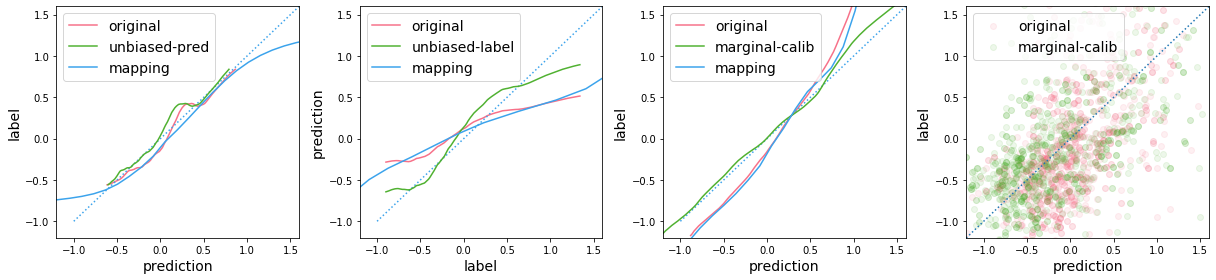

In [34]:
args.knn = 200


def plot_knn(model, data, args, axis='label'):
    k = args.knn
    assert k % 2 == 0

    inputs, labels = data
    inputs = inputs.to(args.device)
    labels = labels.to(args.device).flatten()
    outputs = model(inputs).flatten()

    if axis == 'label':
        ranking = torch.argsort(labels)
    else:
        assert axis == 'prediction'
        ranking = torch.argsort(outputs)

    sorted_labels = labels[ranking]
    sorted_outputs = outputs[ranking]

    smoothed_outputs = F.conv1d(sorted_outputs.view(1, 1, -1), 
                                weight=(1./ (k+1) * torch.ones(1, 1, k+1, device=args.device, requires_grad=False)),
                                padding=k // 2).flatten()
    smoothed_labels = F.conv1d(sorted_labels.view(1, 1, -1), 
                               weight=(1./ (k+1) * torch.ones(1, 1, k+1, device=args.device, requires_grad=False)),
                               padding=k // 2).flatten()
    return smoothed_labels[k//2+1:-k//2-1], smoothed_outputs[k//2+1:-k//2-1]

def plot_calibration(model, data, args):
    inputs, labels = data
    inputs = inputs.to(args.device)
    labels = labels.to(args.device)
    
    outputs = model(inputs)
    
    labels, _ = torch.sort(labels.flatten())
    outputs, _ = torch.sort(outputs.flatten())
    return labels, outputs

def smooth(y, box_pts=100):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='valid')
    return y_smooth

# recalibrator = RecalibratorBias_flow(model, )
model.eval()
import seaborn as sns
palette = sns.color_palette('husl', 3)

plot_lim = [-1.2, 1.6]
fontsize = 14
x = torch.linspace(val_dataset[:][1].min(), val_dataset[:][1].max(), 200).to(device)
with torch.no_grad():
    plt.figure(figsize=(17, 4))
    model.recalibrator = None
    
    plt.subplot(1, 4, 1)
    labels, outputs = plot_knn(model, test_dataset[:], args, axis='prediction')
    plt.plot(smooth(outputs.cpu()), smooth(labels.cpu()), c=palette[0], label='original') 
    plt.plot([-1.0, 2.0], [-1.0, 2.0], linestyle=':', c=palette[2])
    plt.xlabel('prediction', fontsize=fontsize)
    plt.ylabel('label', fontsize=fontsize)
    plt.xlim(plot_lim)
    plt.ylim(plot_lim)
    
    plt.subplot(1, 4, 2)
    labels, outputs = plot_knn(model, test_dataset[:], args, axis='label')
    plt.plot(smooth(labels.cpu()), smooth(outputs.cpu()), c=palette[0], label='original') 
    plt.plot([-1.0, 2.0], [-1.0, 2.0], linestyle=':', c=palette[2])
    plt.xlabel('label', fontsize=fontsize)
    plt.ylabel('prediction', fontsize=fontsize) 
    plt.xlim(plot_lim)
    plt.ylim(plot_lim)
    
    plt.subplot(1, 4, 3)
    labels, outputs = plot_calibration(model, test_dataset[:], args)
    plt.plot(smooth(outputs.cpu()), smooth(labels.cpu()), c=palette[0], label='original')
    plt.plot([-1.0, 2.0], [-1.0, 2.0], linestyle=':', c=palette[2])
    plt.xlabel('prediction', fontsize=fontsize) 
    plt.ylabel('label', fontsize=fontsize)
    plt.xlim(plot_lim)
    plt.ylim(plot_lim)
    

    plt.subplot(1, 4, 1)
    model.recalibrator = recalibrator_bias_f
    labels, outputs = plot_knn(model, test_dataset[:], args, axis='prediction')
    plt.plot(smooth(outputs.cpu()), smooth(labels.cpu()), c=palette[1], label='unbiased-pred') 
    y = recalibrator_bias_f.adjust(x.view(-1, 1))
    plt.plot(x.cpu(), y.detach().cpu(), c=palette[2], label='mapping')
    plt.legend(fontsize=fontsize)
    
    plt.subplot(1, 4, 2)
    model.recalibrator = recalibrator_bias_y
    labels, outputs = plot_knn(model, test_dataset[:], args, axis='label')
    plt.plot(smooth(labels.cpu()), smooth(outputs.cpu()), c=palette[1], label='unbiased-label') 
    y = recalibrator_bias_y.adjust(x.view(-1, 1))
    plt.plot(y.detach().cpu(), x.cpu(), c=palette[2], label='mapping')
    plt.legend(fontsize=fontsize)
    
    plt.subplot(1, 4, 3)
    model.recalibrator = recalibrator_calib
    labels, outputs = plot_calibration(model, test_dataset[:], args)
    plt.plot(smooth(outputs.cpu()), smooth(labels.cpu()), c=palette[1], label='marginal-calib')
    y = recalibrator_calib.adjust(x.view(-1, 1))
    plt.plot(x.cpu(), y.detach().cpu(), c=palette[2], label='mapping')
    plt.legend(fontsize=fontsize)
    
    plt.subplot(1, 4, 4)
    model.recalibrator = None
    inputs, labels = val_dataset[:]
    inputs = inputs.to(args.device)
    labels = labels.to(args.device).flatten()
    outputs = model(inputs)
    adjusted_outputs = recalibrator_calib.adjust(outputs)
    idx = np.random.choice(np.arange(len(labels)), 1000)
    plt.scatter(outputs.cpu()[idx], labels.cpu()[idx], alpha=0.1, c=palette[0], label='original')
    plt.scatter(adjusted_outputs.cpu()[idx], labels.cpu()[idx], alpha=0.1, c=palette[1], label='marginal-calib')
    plt.plot([-1.5, 2.0], [-1.5, 2.0], linestyle=':')
    plt.xlim(plot_lim)
    plt.ylim(plot_lim)
    plt.xlabel('prediction', fontsize=fontsize) 
    plt.ylabel('label', fontsize=fontsize)
    plt.legend(fontsize=fontsize)
    plt.tight_layout()
    plt.savefig('plots/recalib_curve.png')
    
    plt.show()
    


In [35]:

# inputs, labels = test_dataset[:]
# inputs, labels = inputs.to(device), labels.to(device)
# pred = model(inputs).reshape(-1)
# labels = labels.reshape(-1)
# finacial_aid = a(y_0 - pred)
# after_finacial_aid = labels + finacial_aid
# # utility = r(2.+after_finacial_aid) # worked well
# utility = r(3.+after_finacial_aid)
# utility = utility.mean(dim=0)

torch.Size([1836, 17]) torch.Size([1836, 1])
torch.Size([364, 17]) torch.Size([364, 1])


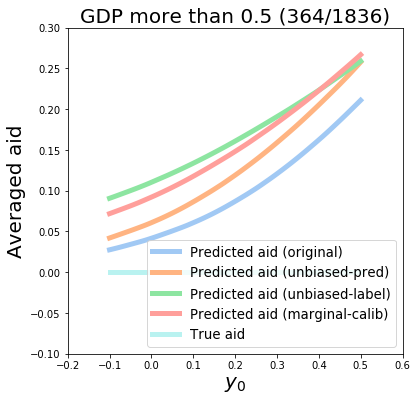

In [131]:
inputs, labels = test_dataset[:]
print(inputs.shape, labels.shape)
total = inputs.shape[0]
value = 0.5
mask = (labels>value).squeeze() # all the data with gdp labels<-0.5
# mask = (labels>1.).squeeze() # all the data with gdp labels<-0.5

labels = labels[mask]
inputs = inputs[mask]
print(inputs.shape, labels.shape)
new_total = inputs.shape[0]
palette = sns.color_palette("pastel")


inputs, labels = inputs.to(device), labels.to(device)
pred = model(inputs).reshape(-1)
labels = labels.reshape(-1)
a=torch.relu
# plt.figure(figsize=(17, 4))
fontsize = 20
linewidth = 5
plt.figure(figsize=(6, 6))

labels_ = []
true_ = []
predicted_ = []
plot_xlim = [-0.2, 0.6]
# plot_ylim = [0, 2.]
plot_ylim = [-0.1, 0.3]
# plot_ylim = [-0.5, 0.5]
# plt.subplot(1, 4, 1)
plt.subplot(1, 1, 1)
for y_0 in np.linspace(-0.1, 0.5, 100):
    model.recalibrator = None
    labels_.append(y_0)
    pred = model(inputs).reshape(-1)
    finacial_aid = a(y_0 - pred)
    true_aid = a(y_0 - labels)
    predicted_.append(finacial_aid.mean().data.item())
    true_.append(true_aid.mean().data.item())
plt.xlim(plot_xlim)
plt.ylim(plot_ylim) 
plt.plot(labels_, predicted_, c=palette[0], label="Predicted aid (original)", linewidth=linewidth)
# plt.scatter(labels_, true_, c=palette[-1], label="True aid")
# plt.legend(fontsize=fontsize)

labels_ = []
true_ = []
predicted_ = []
# plot_xlim = [-0.5, 1.0]
# plot_ylim = [0, 2.]
# plt.subplot(1, 4, 2)
for y_0 in np.linspace(-0.1, 0.5, 100):
    model.recalibrator = recalibrator_bias_f
    labels_.append(y_0)
    pred = model(inputs).reshape(-1)
    finacial_aid = a(y_0 - pred)
    true_aid = a(y_0 - labels)
    predicted_.append(finacial_aid.mean().data.item())
    true_.append(true_aid.mean().data.item())
plt.xlim(plot_xlim)
plt.ylim(plot_ylim) 
plt.plot(labels_, predicted_, c=palette[1], label="Predicted aid (unbiased-pred)", linewidth=linewidth)
# plt.scatter(labels_, true_, c=palette[-1], label="True aid")
# plt.legend(fontsize=fontsize)


labels_ = []
true_ = []
predicted_ = []
# plot_xlim = [-0.5, 1.0]
# plot_ylim = [0, 2.]
# plt.subplot(1, 4, 3)
for y_0 in np.linspace(-0.1, 0.5, 100):
    model.recalibrator = recalibrator_bias_y
    labels_.append(y_0)
    pred = model(inputs).reshape(-1)
    finacial_aid = a(y_0 - pred)
    true_aid = a(y_0 - labels)
    predicted_.append(finacial_aid.mean().data.item())
    true_.append(true_aid.mean().data.item())
plt.xlim(plot_xlim)
plt.ylim(plot_ylim) 
plt.plot(labels_, predicted_, c=palette[2], label="Predicted aid (unbiased-label)", linewidth=linewidth)
# plt.scatter(labels_, true_, c=palette[-1], label="True aid")
# plt.legend(fontsize=fontsize)

labels_ = []
true_ = []
predicted_ = []
# plot_xlim = [-0.5, 1.0]
# plot_ylim = [0, 2.]
# plt.subplot(1, 4, 4)
for y_0 in np.linspace(-0.1, 0.5, 100):
    model.recalibrator = recalibrator_calib
    labels_.append(y_0)
    pred = model(inputs).reshape(-1)
    finacial_aid = a(y_0 - pred)
    true_aid = a(y_0 - labels)
    predicted_.append(finacial_aid.mean().data.item())
    true_.append(true_aid.mean().data.item())
plt.xlim(plot_xlim)
plt.ylim(plot_ylim)
plt.xlabel(r"$y_0$", fontsize=fontsize)
plt.ylabel("Averaged aid", fontsize=fontsize)
plt.plot(labels_, predicted_, c=palette[3], label="Predicted aid (marginal-calib)", linewidth=linewidth)

plt.plot(labels_, true_, c=palette[-1], label="True aid", linewidth=linewidth)
plt.legend(fontsize=fontsize/1.5)

# plt.title("GDP less than {} ({}/{})".format(value, new_total, total), fontsize=fontsize)
plt.title("GDP more than {} ({}/{})".format(value, new_total, total), fontsize=fontsize)

plt.show()

In [132]:
def compute_utility(model, test_dataset, a=torch.relu, r=torch.log, y_0=0.3):
    inputs, labels = test_dataset[:]
    inputs, labels = inputs.to(device), labels.to(device)
    pred = model(inputs).reshape(-1)
    labels = labels.reshape(-1)
    finacial_aid = a(y_0 - pred)
    after_finacial_aid = labels + finacial_aid
    # utility = r(2.+after_finacial_aid) # worked well
    utility = r(3.+after_finacial_aid)
    utility = utility.mean(dim=0)
    return utility, finacial_aid.sum()

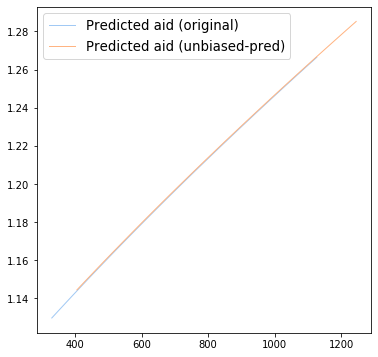

In [165]:
inputs, labels = test_dataset[:]
palette = sns.color_palette("pastel")

plot_xlim = [-0.2, 2.]
plot_ylim = [-0.1, 0.5]
fontsize = 20
linewidth = 1
plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)

labels_ = []
true_0 = []
predicted_ = []
model.eval()
for y_0 in np.linspace(0.0, 0.6, 100):
    model.recalibrator = None
    labels_.append(y_0)
    u, a = compute_utility(model, test_dataset, y_0=y_0)
    
    predicted_.append(u.data.item())
    true_0.append(a.data.item())
# plt.xlim(plot_xlim)
# plt.ylim(plot_ylim) 
plt.plot(true_0, predicted_, c=palette[0], label="Predicted aid (original)", linewidth=linewidth)

labels_ = []
true_1 = []
predicted_ = []
for y_0 in np.linspace(0.0, 0.6, 100):
    model.recalibrator = recalibrator_bias_f
    labels_.append(y_0)
    u, a = compute_utility(model, test_dataset, y_0=y_0)
    predicted_.append(u.data.item())
    true_1.append(a.data.item())
# plt.xlim(plot_xlim)
# plt.ylim(plot_ylim) 
plt.plot(true_1, predicted_, c=palette[1], label="Predicted aid (unbiased-pred)", linewidth=linewidth)

labels_ = []
true_ = []
predicted_ = []
for y_0 in np.linspace(0.0, 0.6, 100):
    model.recalibrator = recalibrator_bias_y
    labels_.append(y_0)
    u, a = compute_utility(model, test_dataset, y_0=y_0)
    
    predicted_.append(u.data.item())
    true_.append(a.data.item())
# plt.xlim(plot_xlim)
# plt.ylim(plot_ylim) 
# plt.plot(true_, predicted_, c=palette[2], label="Predicted aid (unbiased-label)", linewidth=linewidth)

labels_ = []
true_ = []
predicted_ = []
for y_0 in np.linspace(0.0, 0.6, 100):
    model.recalibrator = recalibrator_calib
    labels_.append(y_0)
    u, a = compute_utility(model, test_dataset, y_0=y_0)
    
    predicted_.append(u.data.item())
    true_.append(a.data.item())
# plt.xlim(plot_xlim)
# plt.ylim(plot_ylim) 
# plt.plot(true_, predicted_, c=palette[3], label="Predicted aid (marginal-calib)", linewidth=linewidth)


plt.legend(fontsize=fontsize/1.5)

# plt.title("GDP less than {} ({}/{})".format(value, new_total, total), fontsize=fontsize)
# plt.title("GDP more than {} ({}/{})".format(value, new_total, total), fontsize=fontsize)

plt.show()


In [164]:
# true_0,true_1

In [97]:
# labels, true_aid

In [96]:
# true_